The methodology of varying one input feature while keeping all others fixed at their mean allows us to examine how sensitively and smoothly the model responds to individual features, which in turn provides insight into whether the model has learned generalizable patterns or simply memorized the training data. By inputting synthetic data where only one feature changes across its observed range and all others remain constant, we can plot the predicted output (`TL`) against that feature. If the resulting curve is smooth, continuous, and aligns with expected physical or domain relationships (e.g., `TL` increasing with solar radiation), it suggests that the model has captured meaningful trends and is not overfitting. Conversely, irregular, spiky, or unrealistic responses may indicate that the model is overly sensitive to small variations or noise, a hallmark of overfitting. Thus, this feature sensitivity analysis, while not a direct test, serves as a valuable interpretability tool for detecting overfitting and understanding model behavior.


Using device: cuda
Plotting TL vs AirTemp


/tmp/ipykernel_3340668/2420805513.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))
/home/bel/Desk

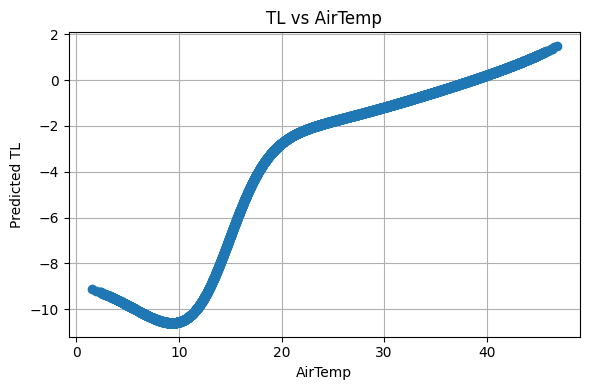

Plotting TL vs Wind


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


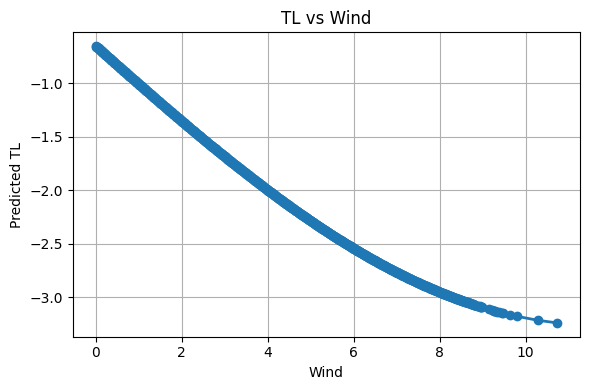

Plotting TL vs Tdp


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


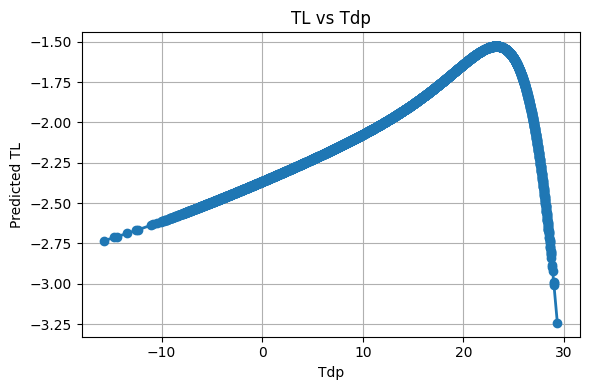

Plotting TL vs Solar


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


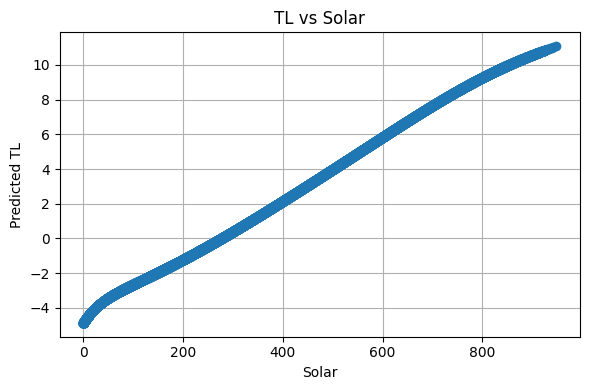

/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


Plotting TL vs sin_doy


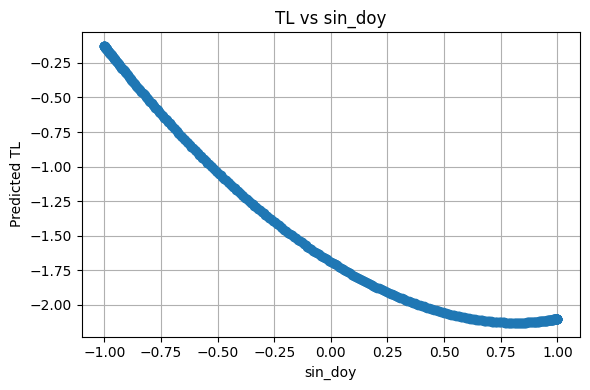

Plotting TL vs cos_doy


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


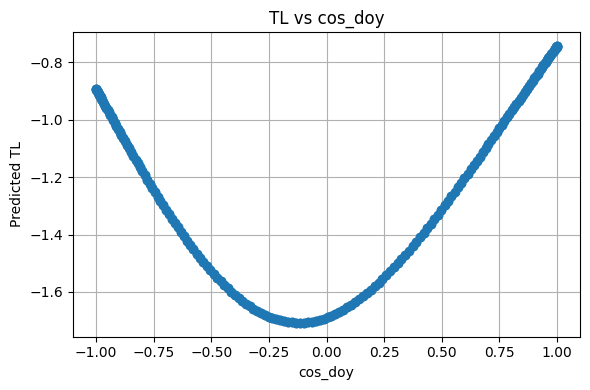

Plotting TL vs sin_hour


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


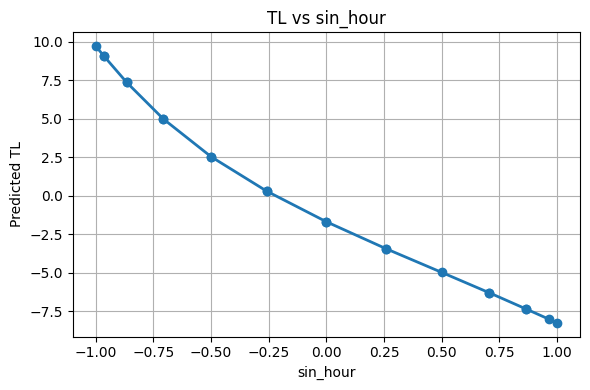

Plotting TL vs cos_hour


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


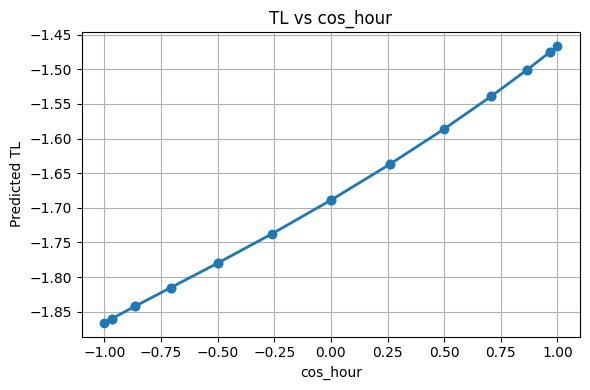

Plotting TL vs Depth


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


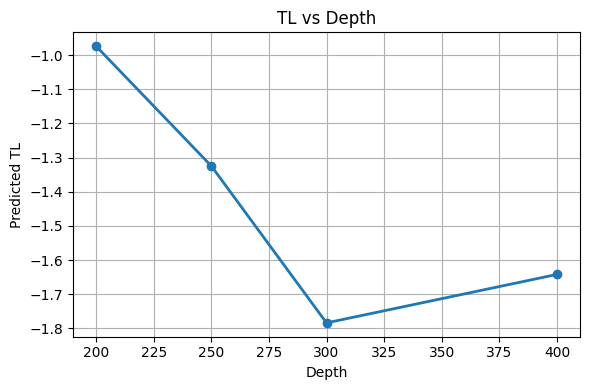

Plotting TL vs Albedo


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


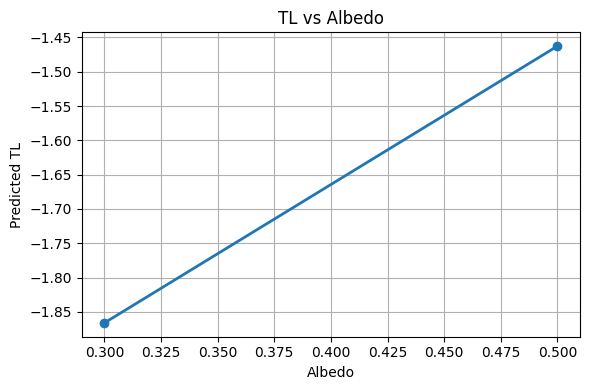

In [4]:
import os
import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# === SETTINGS ===
model_save_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/Model/ann_tl_.pth'
scaler_save_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/scalersann/ann_tl_.save'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === FEATURE NAMES ===
feature_names = ['AirTemp','Wind','Tdp','Solar',
                 'sin_doy','cos_doy','sin_hour','cos_hour',
                 'Depth','Albedo']

# === MODEL DEFINITION ===
class ANN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 12),
            nn.Tanh(),
            nn.BatchNorm1d(12),
            nn.Linear(12, 1)
        )
    def forward(self, x):
        return self.net(x)

# === LOAD CSV FILE (USED FOR RANGE & MEAN) ===
sample_csv = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test/final_file.csv'  # update this path
df = pd.read_csv(sample_csv)

# === FEATURE ENGINEERING ===
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
df = df.dropna(subset=['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['HourOfDay'] = df['Date'].dt.hour
df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

# === FILTER AND CLEAN DATA ===
df = df[['AirTemp','Wind','Tdp','Solar',
         'sin_doy','cos_doy','sin_hour','cos_hour',
         'Depth','Albedo','TL']].dropna()

X_all = df[feature_names]
y_all = df['TL']
X_mean = X_all.mean()

# === LOAD SCALER AND MODEL ===
scaler = joblib.load(scaler_save_path)
model = ANN(len(feature_names)).to(device)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

for feat in feature_names:
    print(f"Plotting TL vs {feat}")

    # Use only unique observed values of the feature
    sweep_values = np.sort(X_all[feat].unique())

    # Create a DataFrame where all features are fixed to mean
    sweep_df = pd.DataFrame([X_mean.values] * len(sweep_values), columns=feature_names)
    sweep_df[feat] = sweep_values  # vary only this feature

    # Scale and convert to tensor
    sweep_scaled = scaler.transform(sweep_df)
    sweep_tensor = torch.tensor(sweep_scaled, dtype=torch.float32).to(device)

    # Predict TL
    with torch.no_grad():
        preds = model(sweep_tensor).cpu().numpy().flatten()

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(sweep_values, preds, lw=2, marker='o')
    plt.xlabel(feat)
    plt.ylabel('Predicted TL')
    plt.title(f'TL vs {feat}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Using device: cuda
Plotting CESR vs AirTemp


/tmp/ipykernel_3936015/1029064463.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))
/home/bel/Desk

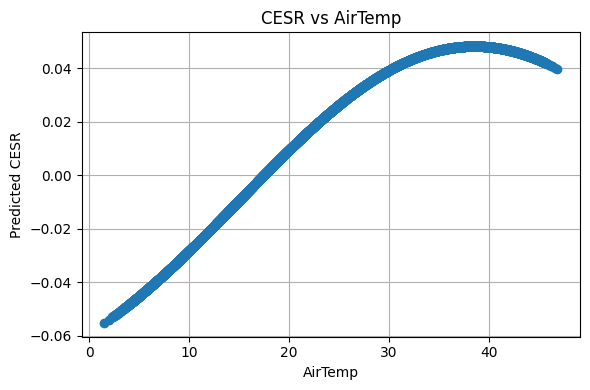

/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


Plotting CESR vs Wind


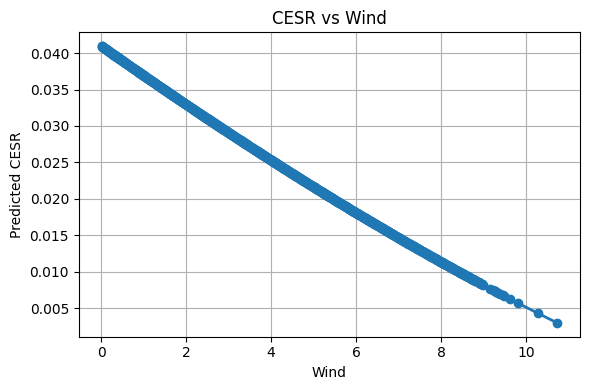

Plotting CESR vs Tdp


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


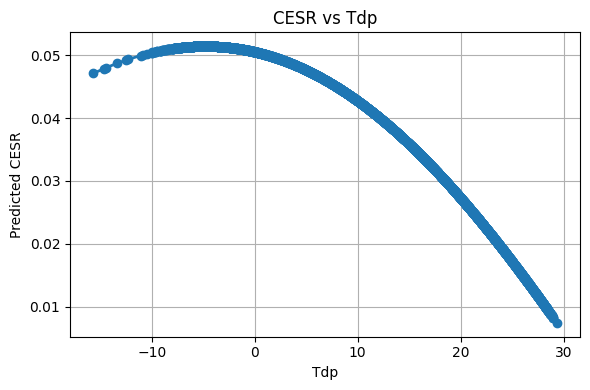

Plotting CESR vs Solar


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


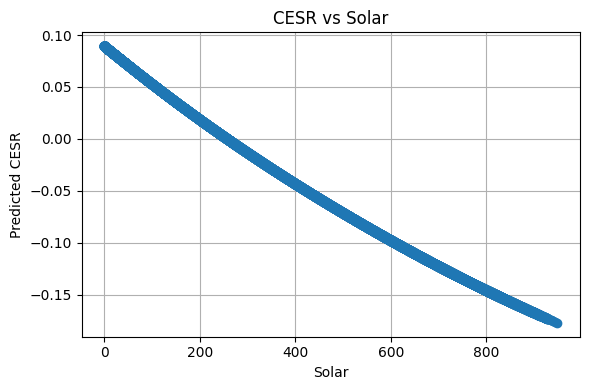

Plotting CESR vs sin_doy


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


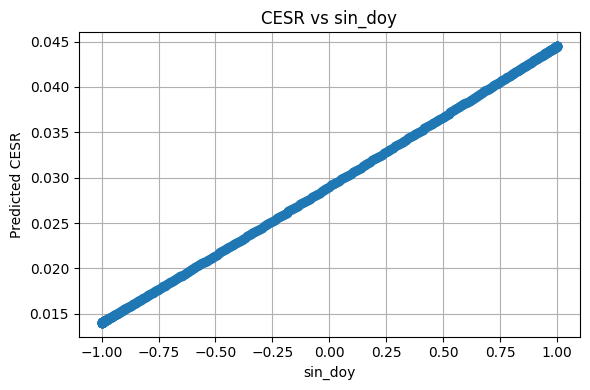

Plotting CESR vs cos_doy


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


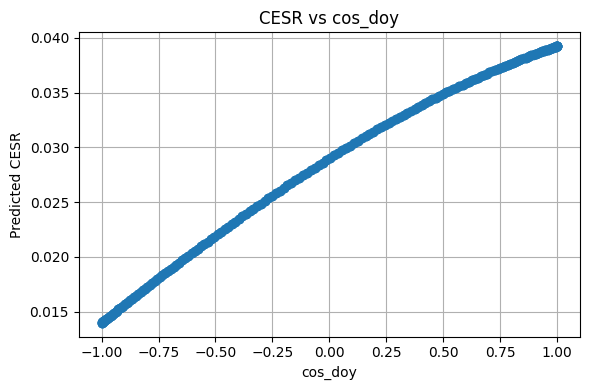

Plotting CESR vs sin_hour


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


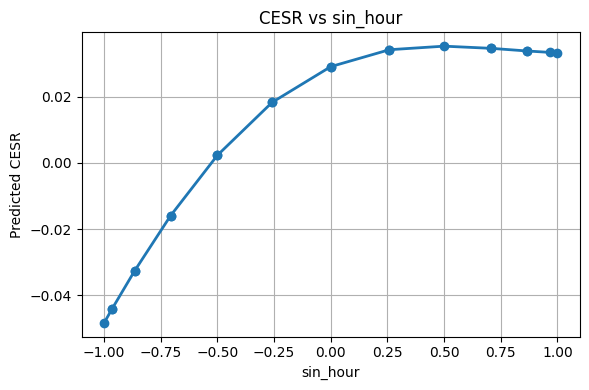

Plotting CESR vs cos_hour


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


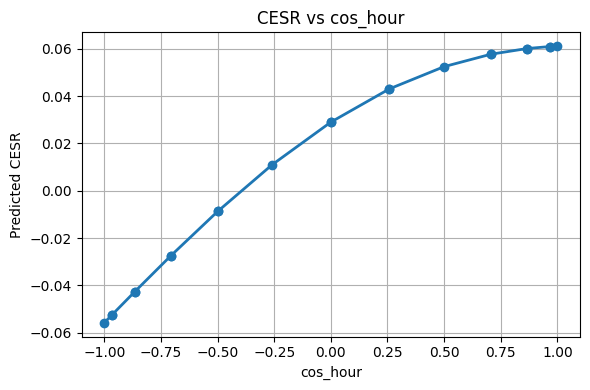

Plotting CESR vs Depth


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


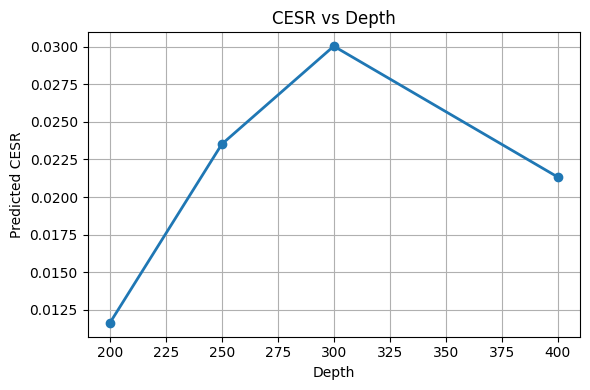

Plotting CESR vs Albedo


/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


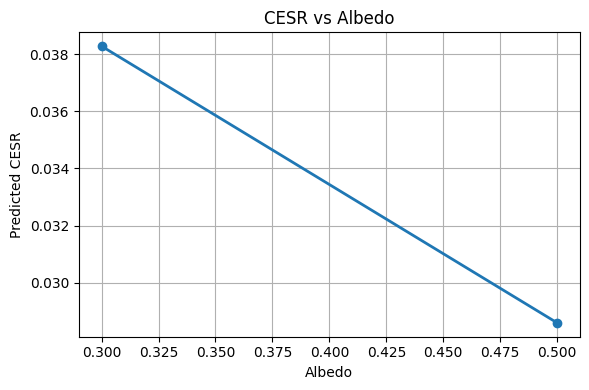

In [2]:
import os
import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# === SETTINGS ===
model_save_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/Model/ann_cesr_.pth'  # updated path
scaler_save_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/ANN/scalersann/ann_cesr_.save'  # updated path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === FEATURE NAMES ===
feature_names = ['AirTemp','Wind','Tdp','Solar',
                 'sin_doy','cos_doy','sin_hour','cos_hour',
                 'Depth','Albedo']

# === MODEL DEFINITION ===
class ANN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 12),
            nn.Tanh(),
            nn.BatchNorm1d(12),
            nn.Linear(12, 1)
        )
    def forward(self, x):
        return self.net(x)

# === LOAD CSV FILE (USED FOR RANGE & MEAN) ===
sample_csv = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test/final_file.csv'
df = pd.read_csv(sample_csv)

# === FEATURE ENGINEERING ===
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
df = df.dropna(subset=['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['HourOfDay'] = df['Date'].dt.hour
df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

# === FILTER AND CLEAN DATA ===
df = df[['AirTemp','Wind','Tdp','Solar',
         'sin_doy','cos_doy','sin_hour','cos_hour',
         'Depth','Albedo','CESR']].dropna()

X_all = df[feature_names]
y_all = df['CESR']
X_mean = X_all.mean()

# === LOAD SCALER AND MODEL ===
scaler = joblib.load(scaler_save_path)
model = ANN(len(feature_names)).to(device)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

for feat in feature_names:
    print(f"Plotting CESR vs {feat}")

    sweep_values = np.sort(X_all[feat].unique())
    sweep_df = pd.DataFrame([X_mean.values] * len(sweep_values), columns=feature_names)
    sweep_df[feat] = sweep_values

    sweep_scaled = scaler.transform(sweep_df)
    sweep_tensor = torch.tensor(sweep_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        preds = model(sweep_tensor).cpu().numpy().flatten()

    plt.figure(figsize=(6, 4))
    plt.plot(sweep_values, preds, lw=2, marker='o')
    plt.xlabel(feat)
    plt.ylabel('Predicted CESR')
    plt.title(f'CESR vs {feat}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
